# 7. Übung Nichtlineare Regelungstechnik 1, Aufgabe 3

## Robuste Auslegung eines Gleitregime-Reglers (Sliding Mode Controller)

System:

\begin{align*}
\dot x_1 &= x_2 + \sin(x_1)\\
\dot x_2 &= a x_1^2 + u
\end{align*}

mit $|a| < 2$

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2019-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitungen für die Simulation

### Benötigte Pakete

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
# Nächsten Befehl Aktivieren für interaktive Plots
# %matplotlib widget

## Definition der rechten Seite der Differentialgleichung

Diese Funktion wird vom Dgl.-Löser aufgerufen, während die Simulation des zeitkontinuierlichen Systems zwischen den Abtastpunkten läuft.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Widerstehen Sie der Versuchung, auf die Systemparameter (hier: a) über den globalen Namensraum zuzugreifen, was in Python prinzipiell möglich ist. Übergeben Sie diese als Funktionsparameter. Python verleitet hier leider leicht zu einem schlampigen Programmierstil a la Microsoft Visual Basic...
</div>

In [2]:
def dgl_sys(t, x, u, a):
    """
    Rechte Seite der Differenzialgleichung des zeitkont. Systems
    """
    x1, x2 = x

    x1_dot = x2 + np.sin(x1)
    x2_dot = a * x1**2 + u

    return [x1_dot, x2_dot]

## Definition des Regelgesetzes

Annahme beim Entwurf: $|a| < 2$.

In [3]:
def sliding_controller(x, para_lambda, para_eta):
    """
    Regelgesetz
    """
    x1, x2 = x
    s = x2 + np.sin(x1) + para_lambda * x1
    return -(para_eta + 2 * x1**2) * np.sign(s) - (np.cos(x1) + para_lambda) * (x2 + np.sin(x1))

## Definition des Stop-Events

Da der Regler das System bei Betrieb außerhalb der Spezifikation nicht stabilisieren kann, muss die Simulation in diesen Fällen abgebrochen werden. Ansonsten werden die Werte der Zustandskomponenten so groß, dass man auf dem Plot nichts erkennen kann. Hierzu wird dem Gleichungslöser diese Funktion übergeben, die ein Stop-Ereignis aulöst, sobald der Abstand des Zustands zum Ursprung größer ist als 10.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. In Matlab ist unter dem Sichwort <a href=https://www.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a> nachzusehen.
</div>

In [4]:
def stop_event(t, x):
    """
    Ereignisfunktion zum Anhalten der Simulation, falls Abstand der
    Zustandstrajektorie zum Ursprung größer als 10
    """
    return np.linalg.norm(x) - 10


stop_event.terminal = True
stop_event.direction = 1

## Einstellungen für die Simulation und Streckenparameter

Variieren Sie den Parameter $a$, um die Robustheit des Entwurfs zu testen.

In [5]:
# Abtastzeit Regler
t_sample = 0.1

# Anzahl Zwischenschritte zwischen Abtastpunkten für zeitkont. Simulation
refine = 20

# Simulationszeit
t_sim = 5

# System- und Reglerparameter
a = -0.2
lamb = 2
eta = 2

# Anfangsbedingung
x10 = 2
x20 = 3

## Initialisierung der benötigten Datencontainer

Die Simulation ist so gestaltet, dass im Array `t_sampled` die Zeitpunkte stehen, an denen der Regler einen neuen Stellwert berechnet, und im Array `t` die Zeitpunkte, zu denen das zeitkontinuierliche System ausgwertet wird.

In [6]:
# Für zeitkontinuierliche Simulation
dt = t_sample/refine
t = np.arange(0, t_sim + dt, dt)
u = np.zeros_like(t)
x = np.zeros((2, t.size))

# Für Abtastschritte
t_sampled = np.arange(0, t_sim + t_sample, t_sample)

# Anfangswert
x[:, 0] = [x10, x20]

## Durchführung der Simulation

Der Regler ist zeitdiskret implementiert und berechnet zu den in `t_sampled` definierten Zeitpunkten einen neuen Stellwert. Zwischen den Abtastzeitpunkten wird das zu regelnde System zeitkontinuierlich mit konstantem Stelleingang simuliert. Für die zeitkontinuierliche Simulation wird `solve_ivp` aus dem SciPy-Paket genutzt ([Dokumentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)).

Da der Löser die rechte Seite der Dgl. mit der Signatur `t, x` erwartet, diese in unserem Falle aber `t, x, u, a` lautet, übergeben wir die Funktion `dgl_sys` über eine lambda-Funktion (Matlab: `@`).

In [7]:
for i, t_s in enumerate(t_sampled[:-1]):
    j = i * refine

    # Reglerausgang für diesen Abtastschritt berechnen
    u[j] = sliding_controller(x[:,j], lamb, eta)

    # Zeitkontinuierliche Simulation für den Zeitraum t_sample mit Auswertung alle dt Sekunden ausgehend vom aktuellen Zeitpunkt
    sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, u[j], a), (t_s, t_s + t_sample), x[:, j], t_eval=np.linspace(t_s, t_s + t_sample, refine + 1), events=[stop_event])

    # Prüfen: War zeitkont. Simulation erfolgreich? Wenn nicht, Schleife verlassen und
    # überflüssig initilisierte Teile der Lösungsarrays entfernen.
    if sol.status == 0:
        x[:, j:(j+refine+1)] = sol.y
        u[j+1:(j+refine+1)] = u[j]  # const während zeitkont. Simu.
    else:
        print("Simulation wegen mutmaßlicher Divergenz abgebrochen bei t = {} s".format(sol.t_events[0][0]))
        u = u[0:j+1]
        x = x[:, 0:j+1]
        t = t[0:j+1]
        break

## Daten der Gleitfläche ermitteln

Unabhänige Variable für das Zeichnen ist hier $x_1$. Der Wertebereich wird so
gewählt, dass er mit dem der Zustandstrajektorie übereinstimmt.

In [8]:
x1s = np.linspace(np.min([0, np.min(x[0,:])]), np.max([0, np.max(x[0,:])]))
x2s = -np.sin(x1s) - lamb * x1s

## Ergebnisse darstellen

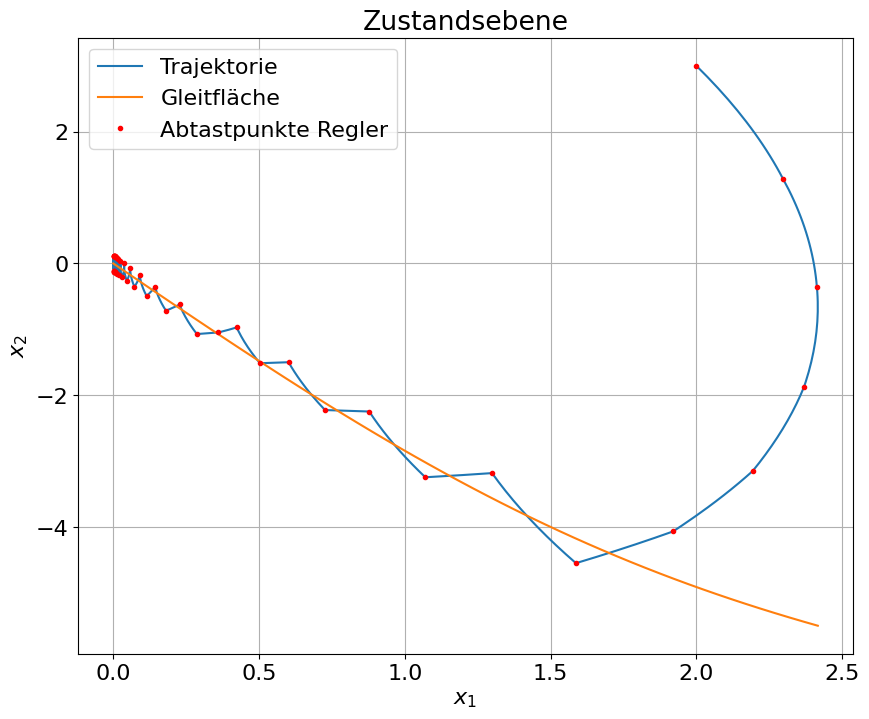

In [9]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
plt.plot(x[0, :], x[1, :], label='Trajektorie')
plt.plot(x1s, x2s, label='Gleitfläche')
plt.plot(x[0, 0:-1:refine], x[1, 0:-1:refine], 'r.', label='Abtastpunkte Regler')  # nur jeden refine.ten Schritt rausgreifen
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Zustandsebene')
plt.grid()

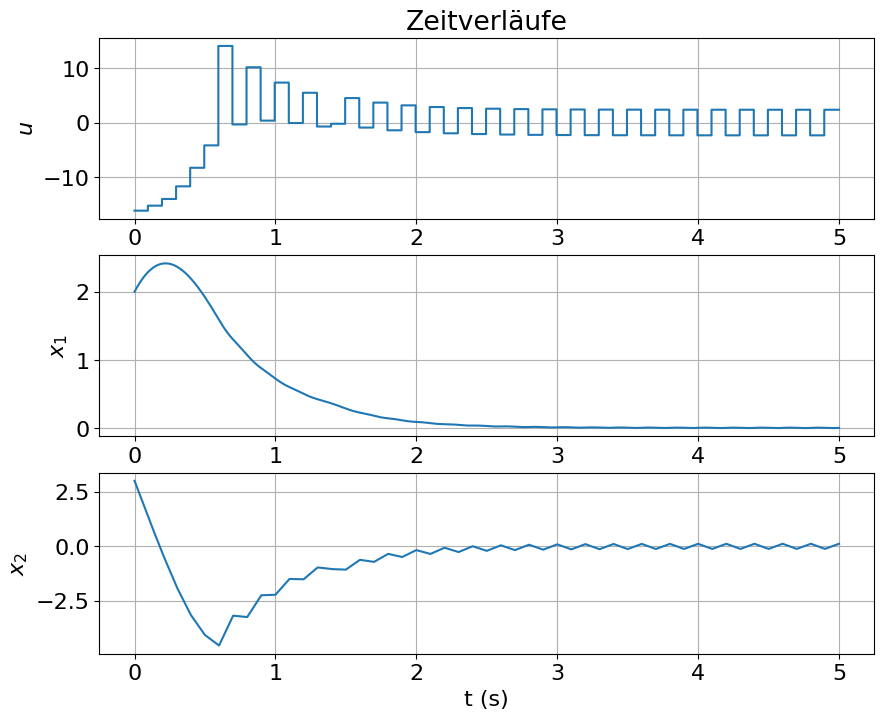

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((10, 8))
ax[0].step(t, u)
ax[0].set_title('Zeitverläufe')
ax[0].set_ylabel('$u$')
ax[0].grid()

ax[1].plot(t, x[0, :])
ax[1].set_ylabel('$x_1$')
ax[1].grid()

ax[2].plot(t, x[1, :])
ax[2].set_ylabel('$x_2$')
ax[2].set_xlabel('t (s)')
ax[2].grid()